[Reference](https://medium.com/@koki_noda/inflation-and-stock-market-61cbeeebaaf5)

In [1]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 3.4 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [2]:
import os
import re
import datetime as dt
from concurrent import futures
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from sklearn.linear_model import LinearRegression
data_dir = "./data/inflation_and_stocks"
os.makedirs(data_dir, exist_ok=True)

# S&P500 Index Historical Data


In [3]:
# get historical data of S&P500(^GSPC)
sp_500 = web.DataReader('^GSPC', 'yahoo', start='1920-01-01', end='2022-05-12')
print(sp_500.shape)
# save the data
sp500_file_path = f"{data_dir}/S&P500.csv"
sp_500.to_csv(sp500_file_path)
sp_500 = pd.read_csv(sp500_file_path, index_col="Date", parse_dates=True)
sp_500.head(3)

(23705, 6)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,0,17.660000
1928-01-03,17.760000,17.760000,17.760000,17.760000,0,17.760000
1928-01-04,17.719999,17.719999,17.719999,17.719999,0,17.719999


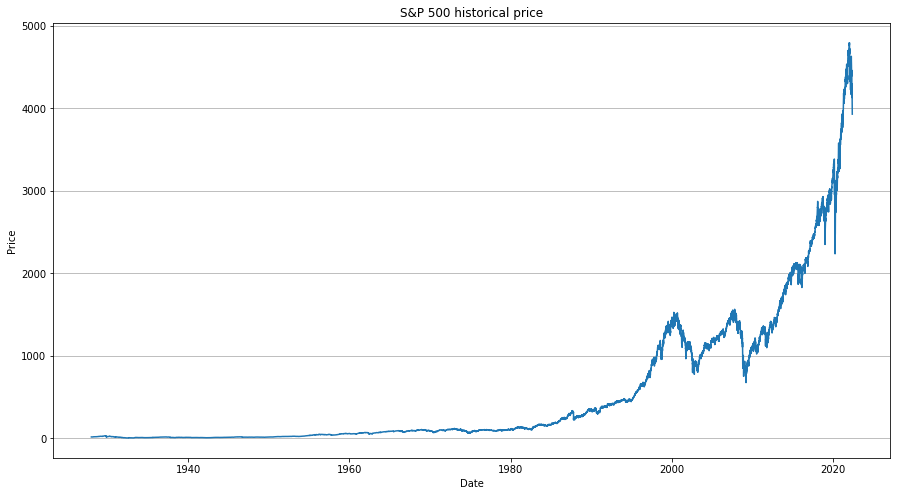

In [4]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(sp_500.index, sp_500["Close"])
ax.grid(axis="y")
ax.set_title("S&P 500 historical price")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
plt.show()

# CPI (annual)


In [5]:
start = dt.datetime(1900, 1, 1)
end = dt.datetime(2022, 5, 12)
cpi_annual = web.DataReader('FPCPITOTLZGUSA', 'fred', start, end)
# save the data
file_path = f"{data_dir}/FPCPITOTLZGUSA.csv"
cpi_annual.to_csv(file_path)
cpi_annual = pd.read_csv(file_path, index_col="DATE", parse_dates=True)
print(cpi_annual.shape)
cpi_annual.tail(3)

(62, 1)


,FPCPITOTLZGUSA
DATE,
2019-01-01,1.812210
2020-01-01,1.233584
2021-01-01,4.697859


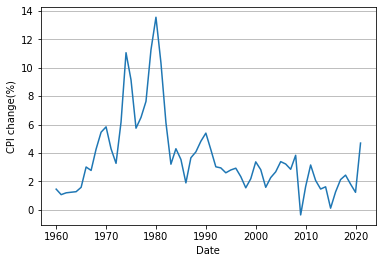

In [6]:
plt.plot(cpi_annual)
plt.grid(axis="y")
plt.xlabel("Date")
plt.ylabel("CPI change(%)")
plt.show()

# CPI (monthly)


In [7]:
start = dt.datetime(1900, 1, 1)
end = dt.datetime(2022, 5, 12)
cpi_monthly = web.DataReader('CPIAUCSL', 'fred', start, end)
# save the data
file_path = f"{data_dir}/CPIAUCSL.csv"
cpi_monthly.to_csv(file_path)
cpi_monthly = pd.read_csv(file_path, index_col="DATE", parse_dates=True)
print(cpi_monthly.shape)
cpi_monthly.tail(3)

(904, 1)


,CPIAUCSL
DATE,
2022-02-01,284.182
2022-03-01,287.708
2022-04-01,288.663


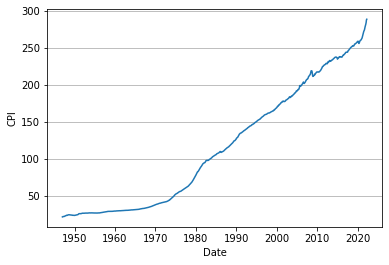

In [8]:
plt.plot(cpi_monthly)
plt.grid(axis="y")
plt.xlabel("Date")
plt.ylabel("CPI")
plt.show()

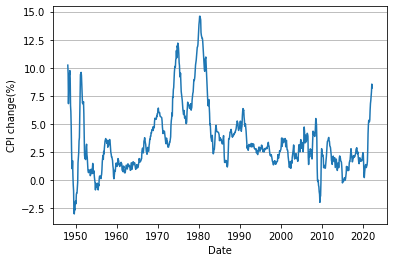

In [9]:
cpi_monthly_change = cpi_monthly / cpi_monthly.shift(12) * 100 - 100
plt.plot(cpi_monthly_change)
plt.grid(axis="y")
plt.xlabel("Date")
plt.ylabel("CPI change(%)")
plt.show()

# CPI vs. S&P 500 Annual Returns


In [10]:
annual_data_list = []
year_list = sp_500.index.year.unique()
for year in year_list:
    last_day_data = sp_500[sp_500.index.year == year].tail(1)
    annual_data_list.append(last_day_data)
sp500_annual = pd.concat(annual_data_list)
sp500_annual_performance = sp500_annual[["Close"]] / sp500_annual[["Close"]].shift(1) * 100 - 100
sp500_annual_performance.index = pd.to_datetime(sp500_annual_performance.index.strftime("%Y"))  # reset index to YYYY-01-01
sp500_annual_performance.tail()

,Close
Date,
2018-01-01,-6.237260
2019-01-01,28.878070
2020-01-01,16.258923
2021-01-01,26.892739
2022-01-01,-17.542352


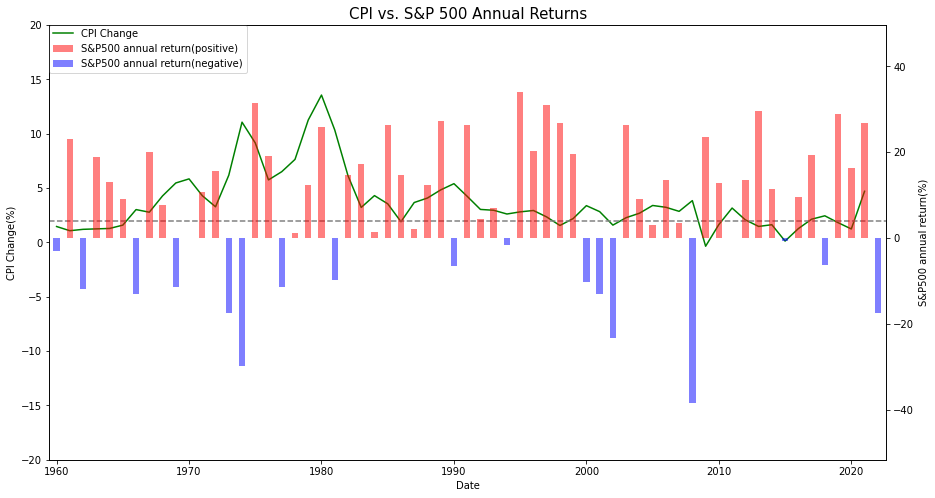

In [11]:
fig, ax1 = plt.subplots(figsize=(15, 8))
ax2 = ax1.twinx()
ax1.plot(cpi_annual.index, cpi_annual,
         color="green", label="CPI Change")
sp500_annual_performance_plus = sp500_annual_performance[sp500_annual_performance >= 0]
ax2.bar(sp500_annual_performance_plus.index, sp500_annual_performance_plus["Close"],
        color="red", alpha=0.5, width=17000 / len(sp500_annual_performance_plus), label="S&P500 annual return(positive)")
sp500_annual_performance_minus = sp500_annual_performance[sp500_annual_performance < 0]
ax2.bar(sp500_annual_performance_minus.index, sp500_annual_performance_minus["Close"],
        color="blue", alpha=0.5, width=17000 / len(sp500_annual_performance_minus), label="S&P500 annual return(negative)")
ax1.axhline(2, color='gray', linestyle='--')
plt.tick_params(labelsize=10)  # font size of tick labels
plt.title("CPI vs. S&P 500 Annual Returns", fontsize=15)
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
ax1.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.)
ax1.set_xlabel("Date")
ax1.set_ylabel("CPI Change(%)")
ax2.set_ylabel("S&P500 annual return(%)")
ax1.set_ylim([-20, 20])
ax1.set_xlim([min(cpi_annual.index) - dt.timedelta(days=200),
              max(cpi_annual.index) + dt.timedelta(days=600)])
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


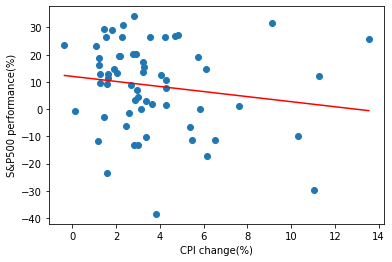

In [12]:
merge_df = pd.merge(cpi_annual, sp500_annual_performance, left_index=True, right_index=True)
merge_df.rename(columns={"FPCPITOTLZGUSA": "CPI", "Close": "SP500"}, inplace=True)
model = LinearRegression()
model_reg = model.fit(merge_df[["CPI"]], merge_df["SP500"])
reg_curve_x = np.linspace(min(merge_df["CPI"]), max(merge_df["CPI"]))
reg_curve_y = model_reg.predict(reg_curve_x.reshape(-1, 1))
plt.scatter(merge_df["CPI"], merge_df["SP500"])
plt.plot(reg_curve_x, reg_curve_y, color="red")
plt.xlabel("CPI change(%)")
plt.ylabel("S&P500 performance(%)")
plt.show()

# CPI vs. S&P 500 Monthly Returns


In [13]:
monthly_data_list = []
month_list = sorted(sp_500.index.month.unique())
for year in year_list:
    for month in month_list:
        last_day_data = sp_500[(sp_500.index.year == year) & (sp_500.index.month == month)].tail(1)
        monthly_data_list.append(last_day_data)
sp500_monthly = pd.concat(monthly_data_list)
sp500_monthly_performance = sp500_monthly[["Close"]] / sp500_monthly[["Close"]].shift(1) * 100 - 100
sp500_monthly_performance.index = pd.to_datetime(
    sp500_monthly_performance.index.strftime("%Y-%m"))  # reset index to YYYY-01-01
sp500_monthly_performance.tail()

,Close
Date,
2022-01-01,-5.258517
2022-02-01,-3.136049
2022-03-01,3.577329
2022-04-01,-8.795671
2022-05-01,-4.885128


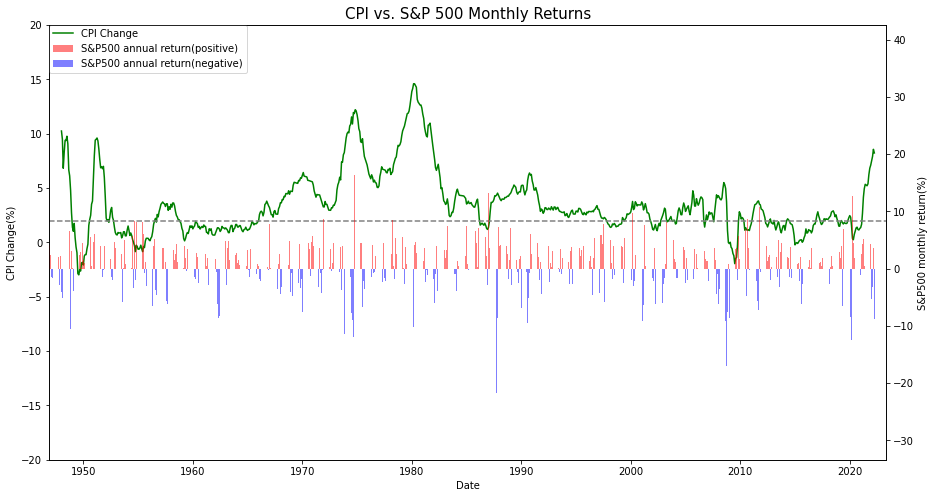

In [14]:
fig, ax1 = plt.subplots(figsize=(15, 8))
ax2 = ax1.twinx()
ax1.plot(cpi_monthly_change.index, cpi_monthly_change,
         color="green", label="CPI Change")
sp500_monthly_performance_plus = sp500_monthly_performance[sp500_monthly_performance >= 0]
ax2.bar(sp500_monthly_performance_plus.index, sp500_monthly_performance_plus["Close"],
        color="red", alpha=0.5, width=17000 / len(sp500_monthly_performance_plus), label="S&P500 annual return(positive)")
sp500_monthly_performance_minus = sp500_monthly_performance[sp500_monthly_performance < 0]
ax2.bar(sp500_monthly_performance_minus.index, sp500_monthly_performance_minus["Close"],
        color="blue", alpha=0.5, width=17000 / len(sp500_monthly_performance_minus), label="S&P500 annual return(negative)")
ax1.axhline(2, color='gray', linestyle='--')
plt.tick_params(labelsize=10)  # font size of tick labels
plt.title("CPI vs. S&P 500 Monthly Returns", fontsize=15)
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
ax1.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.)
ax1.set_xlabel("Date")
ax1.set_ylabel("CPI Change(%)")
ax2.set_ylabel("S&P500 monthly return(%)")
ax1.set_ylim([-20, 20])
ax1.set_xlim([min(cpi_monthly_change.index) - dt.timedelta(days=40),
              max(cpi_monthly_change.index) + dt.timedelta(days=400)])
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


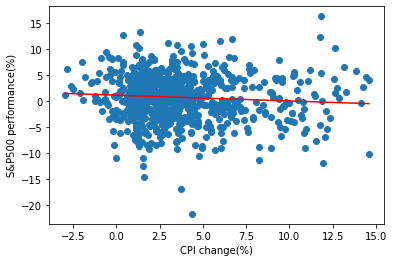

In [15]:
merge_df_monthly = pd.merge(
    cpi_monthly_change,
    sp500_monthly_performance,
    left_index=True,
    right_index=True)
merge_df_monthly.rename(columns={"CPIAUCSL": "CPI", "Close": "SP500"}, inplace=True)
merge_df_monthly.dropna(inplace=True)
model_monthly = LinearRegression()
model_monthly_reg = model_monthly.fit(merge_df_monthly[["CPI"]], merge_df_monthly["SP500"])
reg_curve_monthly_x = np.linspace(min(merge_df_monthly["CPI"]), max(merge_df_monthly["CPI"]))
reg_curve_monthly_y = model_monthly_reg.predict(reg_curve_monthly_x.reshape(-1, 1))
plt.scatter(merge_df_monthly["CPI"], merge_df_monthly["SP500"])
plt.plot(reg_curve_monthly_x, reg_curve_monthly_y, color="red")
plt.xlabel("CPI change(%)")
plt.ylabel("S&P500 performance(%)")
plt.show()